In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from astropy.convolution import convolve, Box1DKernel, Gaussian1DKernel
from astropy.timeseries import LombScargle

In [2]:
%matplotlib inline

In [3]:
plt.style.use('court.mplstyle')

In [4]:
def calc_lomb_scargle(t,y):
   oversample = 10
   tmax = t[-1]#t.max()
   tmin = t[0]#t.min()
   df = 1.0 / (tmax - tmin)
   fmin = df
   fmax = 25 #600 # maximum frequency in cycles per day (c/d)
 
   freq = np.arange(fmin, fmax, df / oversample)
   model = LombScargle(t, y)
   sc = model.power(freq, method="fast", normalization="psd")
 
   fct = np.sqrt(4./len(t))
   amp = np.sqrt(sc) * fct
   return freq*11.574, amp*1E6 # return frequency in muHz and amplitude in ppm

In [5]:
highmass_rc_newvals = pd.read_csv('../datatables/highmass_rc_newvals.csv')
# highmass_rc_newvals

The idea is to take a Kepler light curve, bin it, and see what happens to the data. Does the granulation noise attenuate differently? This will tell us if we need to correct for this attenuation in our calculations

In [6]:
## I'd like to take a nice Kepler light curve with a nice window function
# there are many but I'll start with KIC 3120567

# pull the light curve for this star
original_lc = pd.read_csv('../data/highmass_rc/KIC3120567_LC.csv')
# original_lc

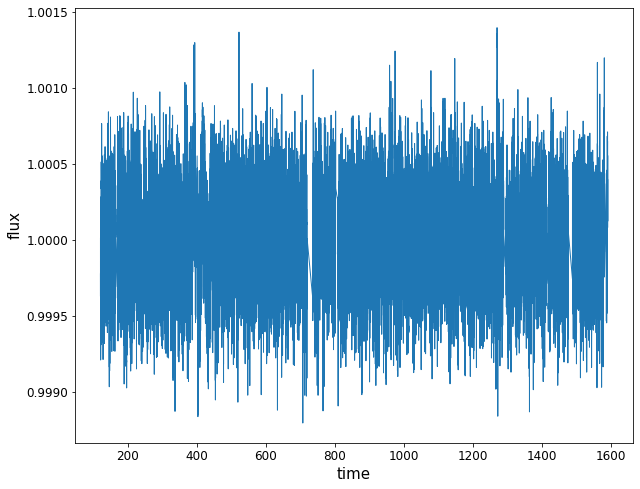

In [7]:
plt.plot(original_lc['time'],original_lc['flux'])
plt.xlabel('time')
plt.ylabel('flux')
plt.show()

In [8]:
original_freq,original_amp = calc_lomb_scargle(np.asarray(original_lc['time']),np.asarray(original_lc['flux']))
original_power = original_amp**2

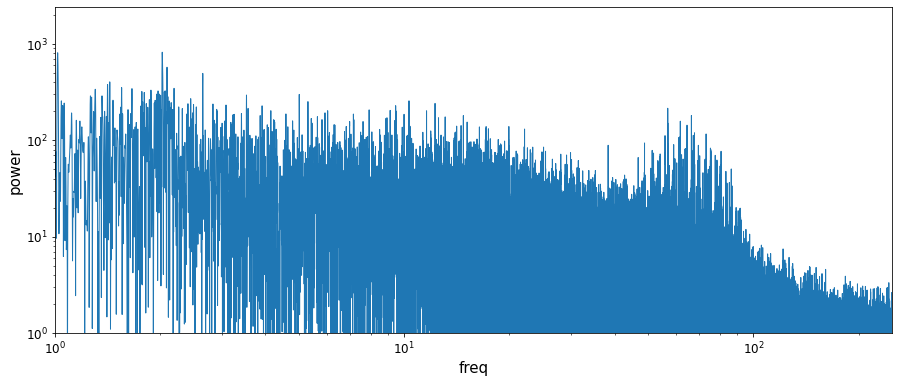

In [9]:
plt.figure(figsize=(15,6))
plt.plot(original_freq,original_power)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('freq')
plt.ylabel('power')
plt.xlim(1,250)
plt.ylim(bottom=10**0)
plt.show()

In [10]:
## we probably want the power density so that observation time doesn't affect the noise level
orig_eff_obs_time = np.round(len(original_lc) * 1800e-6,4) #this is in megaseconds, which will inverse to muHz
orig_eff_obs_time

117.4536

In [11]:
original_powerdensity = original_power*orig_eff_obs_time

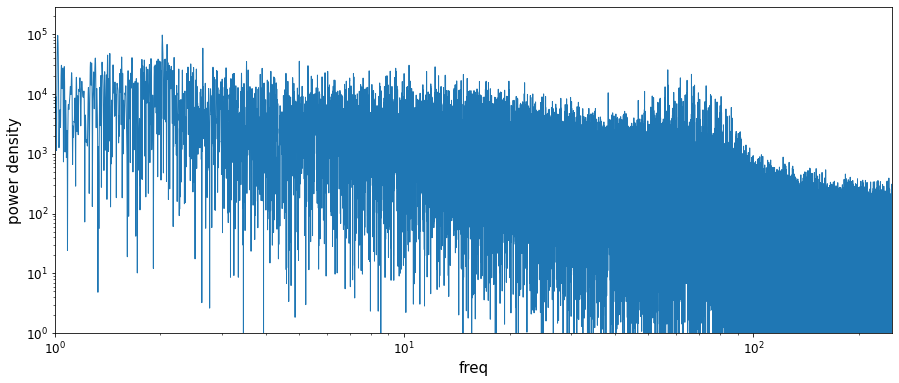

In [12]:
plt.figure(figsize=(15,6))
plt.plot(original_freq,original_powerdensity)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('freq')
plt.ylabel('power density')
plt.xlim(1,250)
plt.ylim(bottom=10**0)
plt.show()

In [13]:
## cool now lets bin the light curve and do all of this again
bins = np.linspace(np.min(original_lc['time']), np.max(original_lc['time']), int(len(original_lc)/1.5))
digitized = np.digitize(original_lc['time'], bins)
bin_means = [original_lc['flux'][digitized == i].mean() for i in range(1, len(bins))]
bin1_lc_time = np.asarray(bins[:-1])
bin1_lc_flux = np.asarray(bin_means)

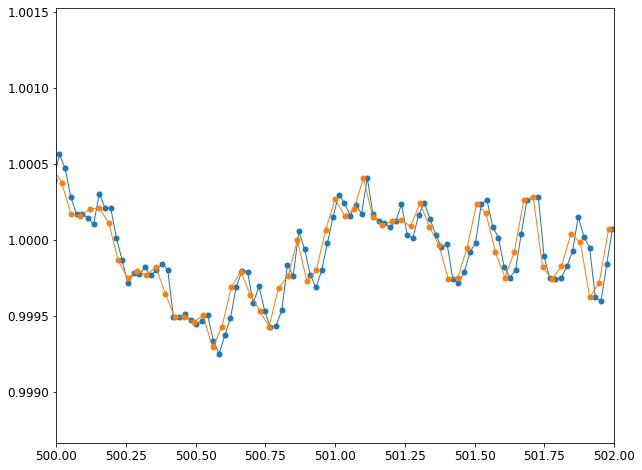

In [14]:
## checking that it looks right because I didn't write that binning code
plt.plot(original_lc['time'],original_lc['flux'],marker='o')
plt.plot(bin1_lc_time,bin1_lc_flux,marker='o')
plt.xlim(500,502)
plt.show()

In [15]:
## now go for the power density
## should the effective observing time be the same????
## I think it should?
# bin_cadence = np.median(np.diff(bin1_lc_time))
# print('binned to',bin_cadence*1440,'minute cadence')
# bin_cadence = (bin_cadence*86400)*1e-6
# print(bin_cadence)
# bin_eff_obs_time = np.round(len(original_lc) * bin_cadence,4) #this is in megaseconds, which will inverse to muHz
# bin_eff_obs_time

In [20]:
## need to remove nans after the binning
nan_mask = []
for i in range(0,len(bin1_lc_flux)):
    if bin1_lc_flux[i]==bin1_lc_flux[i]:
        nan_mask.append(True)
    else:
        nan_mask.append(False)
# nan_mask = np.where(bin1_lc_flux==bin1_lc_flux,True,False)
# nan_mask = np.asarray(nan_mask)
# nan_mask

In [17]:
bin1_freq,bin1_amp = calc_lomb_scargle(bin1_lc_time[nan_mask],bin1_lc_flux[nan_mask])
bin1_power = bin1_amp**2
bin1_powerdensity = bin1_power*orig_eff_obs_time

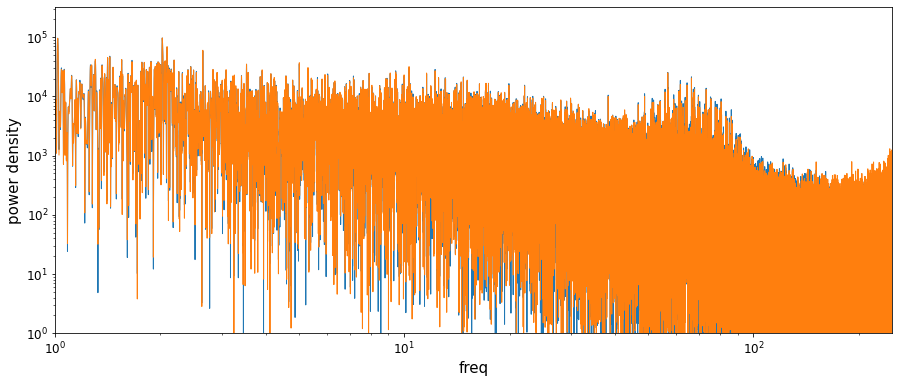

In [19]:
plt.figure(figsize=(15,6))
plt.plot(original_freq,original_powerdensity)
plt.plot(bin1_freq,bin1_powerdensity)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('freq')
plt.ylabel('power density')
plt.xlim(1,250)
plt.ylim(bottom=10**0)
plt.show()

In [21]:
## plop that bad boi into a function
def generate_binned_data(time,flux,scale_factor):
    bins = np.linspace(np.min(time), np.max(time), int(len(time)/scale_factor))
    digitized = np.digitize(time, bins)
    bin_means = [flux[digitized == i].mean() for i in range(1, len(bins))]
    bin_time = np.asarray(bins[:-1])
    bin_flux = np.asarray(bin_means)
    nan_mask = []
    for i in range(0,len(bin_flux)):
        if bin_flux[i]==bin_flux[i]:
            nan_mask.append(True)
        else:
            nan_mask.append(False)
    bin_freq,bin_amp = calc_lomb_scargle(bin_time[nan_mask],bin_flux[nan_mask])
    bin_power = bin_amp**2
    bin_powerdensity = bin_power*orig_eff_obs_time
    
    return bin_time[nan_mask],bin_flux[nan_mask],bin_freq,bin_power,bin_powerdensity

/var/folders/5_/9nz8zb3j1nd7ngnmb4btgpjh0000gq/T/ipykernel_83556/3440149889.py:14: RuntimeWarning: invalid value encountered in sqrt
  amp = np.sqrt(sc) * fct


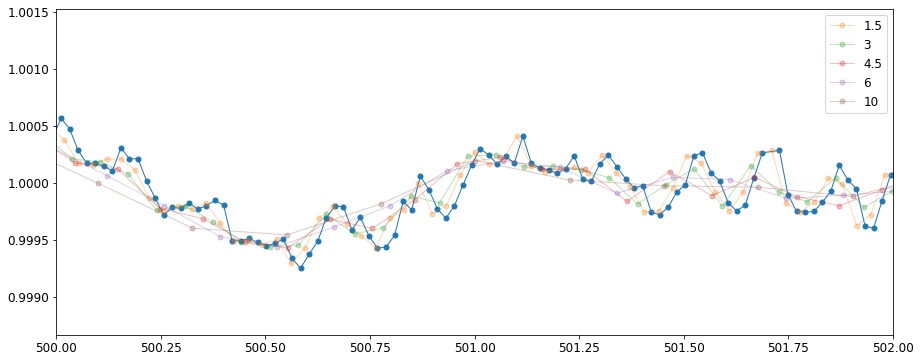

In [36]:
scale_factors = [1.5,3,4.5,6,10]

plt.figure(figsize=(15,6))
# plt.plot(original_freq,original_powerdensity,label='original',alpha=0.7)

## checking that it looks right because I didn't write that binning code
plt.plot(original_lc['time'],original_lc['flux'],marker='o')
# plt.plot(bin1_lc_time,bin1_lc_flux,marker='o')

for scale_factor in scale_factors:
    bin_time,bin_flux,bin_freq,bin_power,bin_powerdensity = generate_binned_data(original_lc['time'],
                                                                                 original_lc['flux'],
                                                                                scale_factor)
#     plt.plot(bin_freq,bin_powerdensity,label=scale_factor,alpha=0.3)
    
    interpolation_function = sp.interpolate.interp1d(original_freq,original_powerdensity,kind='slinear')
    resampled_original = interpolation_function(bin_freq[:-10])
    
#     plt.plot(bin_freq[:-10],bin_powerdensity[:-10]/resampled_original,label=scale_factor,alpha=0.3)
    
    plt.plot(bin_time,bin_flux,marker='o',label=scale_factor,alpha=0.3)

plt.xlim(500,502)
    
# plt.xscale('log')
# plt.yscale('log')
# plt.xlabel('freq')
# plt.ylabel('binned power density/original power density')
# plt.axhline(1,color='k')
# plt.xlim(1,250)
# plt.xlim(10,150)#250)
# plt.ylim(bottom=10**0)
plt.legend()
plt.show()